In [1]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '../..')
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from src import measurements as measure
from src import ket as ket
from src import density_matrix as DM

In [13]:
data = dict(h5py.File("../../data/Jackson_mass_submit_tutorial/Jackson_mass_submit_tutorial.hdf5"))

In [4]:
def get_pops(data, n_qubits, connectivity):
    #dimension 0 is each trial
    #dimension 1 is each time step
    #dimension 2 is each qubit
    result = []
    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 2']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 2'][f'unitary seed {seed}'][f'ordering seed {seed}']['pops'])
        dat = {int(k):dat[k] for k in dat}
        dat = np.array([np.array([dat[k][subkey][()] for subkey in sorted(dat[k])]) for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

def get_2_qbit_dms(data, n_qubits, connectivity):
    basis = ket.canonical_basis(2)
    #dimension 0 is each trial
    #dimension 1 is each time step (recall that sampling step is 5 by default)
    #dimension 2 is qubit pair
    #dimension 3 and 4 is the 2 qubit density matrix
    result = []
    
    def to_tuple(string):
        tuple_elements = string.strip('()').split(',')
        return tuple(int(elem.strip()) for elem in tuple_elements)

    for trial in data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 2']:
        seed = trial.split(' ')[-1]
        dat = dict(data[f'{n_qubits} qubits'][f'{connectivity} connectivity']['unitary energy subspace 2'][f'unitary seed {seed}'][f'ordering seed {seed}']['two_qubit_dms'])
        dat = {int(k):dat[k] for k in dat}
        
        dat = np.array([{to_tuple(subkey):DM.DensityMatrix(dat[k][subkey],basis) for subkey in sorted(dat[k])} for k in sorted(dat)])
        result.append(dat)
    return(np.array(result))

In [17]:
data

{'12 qubits': <HDF5 group "/12 qubits" (4 members)>,
 '8 qubits': <HDF5 group "/8 qubits" (3 members)>}

In [57]:
sizes = [8,12]
temps = ['cold','hot']
result = {s:{t:{} for t in temps} for s in sizes}
for size in sizes:
    for connectivity in data[f'{size} qubits']:
        print(f'{size} qubits {connectivity}')
        pops = get_pops(data,size,connectivity[:-13])
        extractable_work = np.array([[measure.extractable_work_of_each_qubit_from_pops(p) for p in time_slice ]for time_slice in pops ])
        change_in_ex_work = np.diff(extractable_work,axis = 1)
        hot__percent_greater_0 = np.mean(change_in_ex_work[:,:,(0,4)]>0,axis = 1).flatten()
        cold_percent_greater_0 = np.mean(change_in_ex_work[:,:,(1,2,3,5,6,7)]>0,axis = 1).flatten()
        result[size]['hot'][connectivity] = hot__percent_greater_0
        result[size]['cold'][connectivity] = cold_percent_greater_0

8 qubits c5 connectivity
8 qubits c6 connectivity
8 qubits c7 connectivity
12 qubits c5 connectivity
12 qubits c6 connectivity
12 qubits c7 connectivity
12 qubits gas connectivity


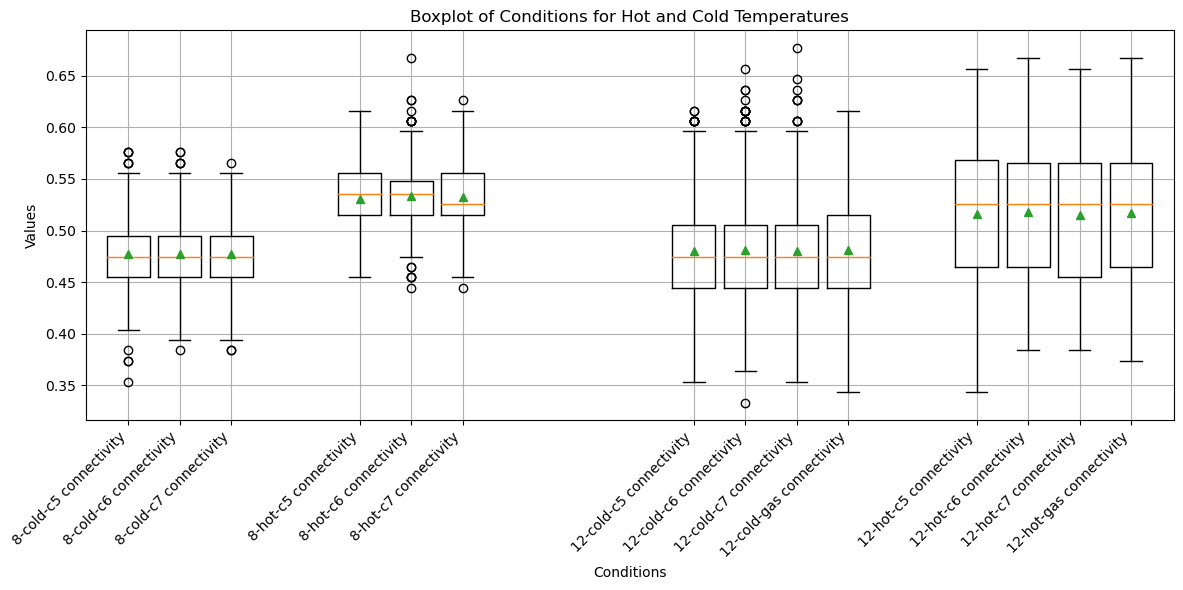

In [58]:
# Extracting data for plotting
labels = []
all_data = []
positions = []
num_subgroups = sum(len(inner_dict) for outer_dict in result.values() for inner_dict in outer_dict.values())

i,j,k=0,0,0
for outer_key, outer_value in result.items():
    i+=1
    for inner_key, inner_value in outer_value.items():
        j+=1
        for innermost_key, innermost_value in inner_value.items():
            k+=1
            labels.append(f"{outer_key}-{inner_key}-{innermost_key}")
            all_data.append(innermost_value)
            positions.append(1.2*i+.9*j+.6*k)

# Creating boxplot with custom positions
num_boxes = len(all_data)
num_outer_keys = len(result)
group_gap = 3  # adjust the gap between groups


plt.figure(figsize=(12, 6))
plt.boxplot(all_data, positions=positions, showmeans=True)

plt.xticks(positions, labels, rotation=45, ha='right')
plt.xlabel('Conditions')
plt.ylabel('Values')
plt.title('Boxplot of Conditions for Hot and Cold Temperatures')
plt.grid(True)
plt.tight_layout()
plt.show()

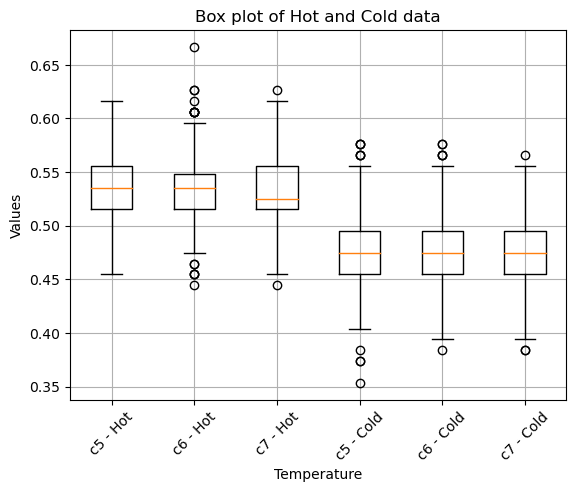

In [6]:

# Extracting data for box plot
hot_data = [result[key]['hot'] for key in result.keys()]
cold_data = [result[key]['cold'] for key in result.keys()]
labels = [f'{key} - Hot' for key in result.keys()] + [f'{key} - Cold' for key in result.keys()]



# Creating box plot
plt.boxplot(hot_data + cold_data, labels=labels)
plt.xlabel('Temperature')
plt.ylabel('Values')
plt.title('Box plot of Hot and Cold data')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:

for time_index in two_qubit_dms_example:
    G = nx.Graph()
    processed_data = {}
    for key in two_qubit_dms_example[time_index]:
        processed_data[key] = DM.DensityMatrix(two_qubit_dms_example[time_index][key],basis)
    mutual_information = measure.mutual_information_of_every_pair_dict(processed_data)
    
    weighted_edges = []
    for key in mutual_information:
        mi = mutual_information[key]
        key = eval(key)
        
        G.add_edges_from([(key[0],key[1],{"mi":mi})])
        
    edges, weights = zip(*nx.get_edge_attributes(G, 'mi').items())

    # Normalize the weights to range [0, 1] for color mapping
    weights = [((w - min(weights)) / (max(weights) - min(weights))) for w in weights]
    
    pos = nx.spring_layout(G, seed=42)  # Define the layout for the nodes
    nx.draw(G,pos,with_labels=True, node_color='lightblue', node_size=200, font_size=10,edge_color=weights, edge_cmap=plt.cm.Blues, width=2)
    plt.gca().set_aspect('equal')
    plt.savefig(f"../../data/images/{time_index}.png")

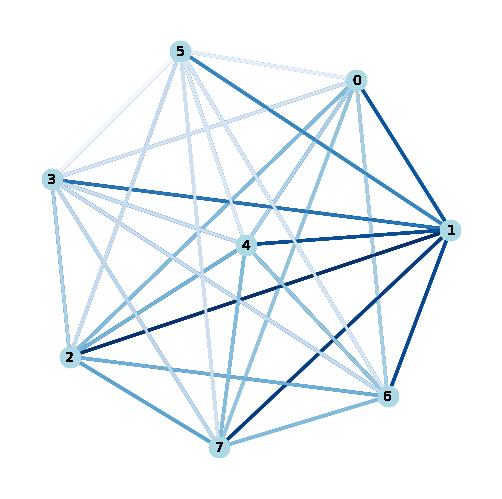

In [13]:


for time_index in two_qubit_dms_example:
    G = nx.Graph()
    processed_data = {}
    for key in two_qubit_dms_example[time_index]:
        processed_data[key] = DM.DensityMatrix(two_qubit_dms_example[time_index][key],basis)
    mutual_information = measure.mutual_information_of_every_pair_dict(processed_data)
    
    weighted_edges = []
    for key in mutual_information:
        mi = mutual_information[key]
        key = eval(key)
        
        G.add_edges_from([(key[0],key[1],{"mi":mi})])
        
    edges, weights = zip(*nx.get_edge_attributes(G, 'mi').items())

    # Normalize the weights to range [0, 1] for color mapping
    weights = [((w - min(weights)) / (max(weights) - min(weights))) for w in weights]
    
    pos = nx.spring_layout(G, seed=42)  # Define the layout for the nodes
    nx.draw(G,pos,with_labels=True, node_color='lightblue', node_size=200, font_size=10,edge_color=weights, edge_cmap=plt.cm.Blues, width=2)
    plt.gca().set_aspect('equal')
    plt.savefig(f"../../data/images/{time_index}.png")